# SPARK SQL (CLOUDS Fall 2018)

In this notebook, we will learn how to use the DataFrame API and SparkSQL to perform simple data analytics tasks.

# Goals
The main goals of this notebook are the following:
1. Understand the advantages and disadvantages of using DataFrame over RDD
2. Analyze the airline data with the DataFrame API and SparkSQL

# Steps

- First, in section 1, we will go through a short introduction about the DataFrame API with a small example to see how can we use it and how it compares to the low-level RDD abstraction.
- In section 2, we delve into the details of the use case of this notebook including: providing the context, introducing the data
- In section 3, we perform data exploration and analysis

# 1. RDD and DataFrame APIs

In our previous notebooks, we have worked with RDDs (Resilient Distributed Dataset), the basic abstraction in Spark. The main reason is due to the task at hand: we have been invovled in the design of distributed algorithms.

In this laboratory session, we study (or revisit) the DataFrame API - an immutable distributed collection of data.
DataFrames allow developers to impose a **structure** on a distributed collection of data, allowing higher-level abstraction; in addition, DataFrames provide a domain specific language (DSL) API to manipulate distributed, structured data. Ultimately, the goal is to make Spark accessible to a wider audience, beyond researchers and specialized data engineers.

Let's take a small example to see the difference between RDDs and DataFrames. The two cells below contain short code snippets that perform the same task: count the frequency of words in a document, then sort the result in descending order. The first snippet is the same you have been working on in the very [first notebook](https://github.com/EURECOM-CLOUDS-COURSE/Introduction/blob/master/introduction-lab.ipynb) of the CLOUDS course.
The second code snippet uses the DataFrame API.

<div class="alert alert-block alert-info">

<strong>Question 1.</strong> 

Run both approaches (RDD and DataFrame) detailed below, compare their runtime, and discuss. Is the DataFrame API approach faster? Can you explain why?

</div>

In [1]:
import time
time_start = time.time()
words = (
            # read the text file
            sc.textFile("/datasets/gutenberg/gutenberg_small.txt").repartition(16)
            
            # construct words from lines
            .flatMap(lambda line: line.split())
            
            # map each word to (word, 1)
            .map(lambda x: (x, 1))
    
            # reduce by key: accumulate sum the freq of the same word
            .reduceByKey(lambda freq1, freq2: freq1 + freq2)
            
            # swap (word, freq) to (freq, word)
            .map(lambda x: (x[1], x[0]))
    
            # sort result by key DESC
            .sortByKey(False)
         )
print("Runtime: %.2f sec" % (time.time() - time_start))
print(words.take(5))

Runtime: 179.21 sec
[(29556020, 'the'), (18043957, 'of'), (14914748, 'and'), (12892052, 'to'), (9779124, 'a')]


In [2]:
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import explode, split, desc
sqlContext = SQLContext(sc)
time_start = time.time()

# read the text file
df = sqlContext.read.text("/datasets/gutenberg/gutenberg_small.txt")

# show 3 samples
# df.show(3)

result = (
    # split into words
    df.select(explode(split(df.value, "\s+|\t+")).alias('word'))
    
    # group by each word
    .groupBy(['word'])
    
    # count the freq
    .count()
    
    # sort the result
    .orderBy(desc("count"))
)

result.show(5)
print("Runtime: %.2f sec" % (time.time() - time_start))

+----+--------+
|word|   count|
+----+--------+
| the|29556020|
|  of|18043957|
|    |16611988|
| and|14914748|
|  to|12892052|
+----+--------+
only showing top 5 rows

Runtime: 120.48 sec


#### Response: 
<div class="alert alert-info">
The speed of the DataFrame API approach is faster than the RDD, this is due to the optimizations built into the DataFrames.   
    
This happens because the Dataframe is a Dataset (distributed collection of data) organized as in a table which means that, unlike the basic Spark RDD API, the interfaces provided by Spark SQL provides Spark with more information about the structure of both the data and the computation being performed, allowing internal extra optimizations on the finalized query.      
The biggest difference between RDDs and DataFrames, is that operations on RDDs are imperative and run through the transformations and actions in order whereas operations on DataFrames are optimizable by Spark. This means that when some operations have to be executed with RDDs, those are always performed in the specified order, while the DataFrame will actually be run through an optimizer, which will create a query plan with the operations reorganized to be more efficient without changing the result.

    
</div>

# 2. Analysis of flight data using the DataFrame API and SparkSQL

## Use case

In this notebook, we play the role of a data scientist working in the travel industry, specifically on air transportation of passengers. We want to explore the data collected by the Department of Transportation (DoT) to understand passengers' behavior, as well as the properties of all flights, across several airline companies.

The dataset provided by the DoT has 29 features, that can be either categorical or numerical. For example, the ```src_airport``` (source airport) is categorical: there exist no comparison operator between airport names. We can not say "SGN is bigger than NCE". The ```departure_time``` feature is numerical, for which a comparison operator exists. For instance, "flight departing before 6PM" can be express by "departure_time < 1800".

In this use case, most features are numerical, except carrier, flight_number, cancelled, cancelation_code and diverted. 
The data contains a header, that is useless when analyzing the data: it serves the purpose of an "embedded schema", to help data scientist figure out what information is available. Note that there are some features with missing values in some lines of the dataset. The missing values are marked by "NA". These values can cause problems when processing the data and can lead to unexpected results. Therefore, we need to remove the header and replace all "NA" values by empty values, such as they can be interpreted as null values.

## DataFrame
As we have seen already, there are multiple ways to manipulate data:

- Using the RDD abstraction

- Using the DataFrame abstraction. 

A DataFrame is a distributed collection of data organized into named columns. It is based on the data frame concept in R language or in Pandas for Python. In some sense, it is similar to a table in a relational database: each item is a list of values (the columns). Also, the value in each row of each column can be accessed by the column's name.

To use DataFrames, the data should be clean (no invalid values). That means we cannot create DataFrame directly from the "RAW" data. Instead, we will first create an RDD from RAW data, produce a new, clean RDD, then transform it to a DataFrame and work on it. The RDD `cleaned_data` is an `RDD[String]`. We need to transform it to `RDD[(TypeOfColumn1, TypeOfColumn2, ..., TypeOfColumn29)]` then call a function to create a DataFrame from the new RDD. Please note that, package `com.databricks.spark.csv` can really help us to load the data efficiently without concerns about parsing, conversions, etc... However, the CSV package can have some problems when loading not well-formatted data or the data that has many kinds of missing values. The guidelines defined this notebook are a general way to help you work with any data.


DataFrames can be constructed from a wide array of sources such as: structured data files, tables in Hive, external databases, or existing RDDs.

During the labs in this course, we will mainly work with CSV data files. So, in the next sections, we only focus on constructing dataframes from structured data files directly and from existing RDD.

### Constructing a DataFrame directly from structured data file

To construct DataFrame from a structured file directly, the file type must be supported. Currently, Spark supports csv, json, avro and many more. Among these types, the csv type is one of the most popular in data analytics. A DataFrame is constructed from csv files by using the package spark-csv from Databricks.


In [3]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

df = sqlContext.read.load('/datasets/airline/1994.csv', 
    format='com.databricks.spark.csv', 
    header='true', 
    inferSchema='true',
    nullValue='NA'
)

Using the function load parametrized with `com.databricks.spark.csv`, we ask the SqlContext to use the parser from the DataBricks package. Additionally, we can specify whether the file has a header, or ask the parser to guess the data type of columns automatically. The parsed data types is viewed using the function printSchema.

In [4]:
# print(df.dtypes)
df.printSchema()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- CRSDepTime: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nullable = true)
 |

As you can see, the automatically inferred data types are **not** as expected. For example, we expect that `CRSDepTime` to be of interger type. The type and the name of each column can be modified using function ```withColumn``` and ```withColumnRename``` respectively. Additionally, we can also compute and print basic descriptive statistics of numerical columns via the function ```describe``` (similar to Pandas).

In [5]:
df = (df
          # change type of column CRSDepTime by casting its values to interger type
          .withColumn('CRSDepTime', df.CRSDepTime.cast('int'))

          # rename the column
          .withColumnRenamed('CRSDepTime', 'scheduled_departure_time')
    )

# print schema of the current data
df.printSchema()

# run jobs to calculate basic statistic information and show it
df.describe().show()

root
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)
 |-- DayofMonth: integer (nullable = true)
 |-- DayOfWeek: integer (nullable = true)
 |-- DepTime: integer (nullable = true)
 |-- scheduled_departure_time: integer (nullable = true)
 |-- ArrTime: integer (nullable = true)
 |-- CRSArrTime: integer (nullable = true)
 |-- UniqueCarrier: string (nullable = true)
 |-- FlightNum: integer (nullable = true)
 |-- TailNum: string (nullable = true)
 |-- ActualElapsedTime: integer (nullable = true)
 |-- CRSElapsedTime: integer (nullable = true)
 |-- AirTime: string (nullable = true)
 |-- ArrDelay: integer (nullable = true)
 |-- DepDelay: integer (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Dest: string (nullable = true)
 |-- Distance: integer (nullable = true)
 |-- TaxiIn: string (nullable = true)
 |-- TaxiOut: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- CancellationCode: string (nullable = true)
 |-- Diverted: integer (nulla

### Constructing a DataFrame from an existing RDD

Another way to construct a DataFrame is using data from an existing RDD. The main advantage of this approach is that it does not need a third party library. However, with this method, we have to remove the header ourself and provide a clear schema.



In [8]:
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import explode, split, desc, col, udf, round
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import pyspark.sql.functions as func
import matplotlib.patches as mpatches
import seaborn as sns

sqlContext = SQLContext(sc)

data = sc.textFile('/datasets/airline/1994.csv')

# extract the header
header = data.first()

# replace invalid data with NULL and remove header
cleaned_data = (
        data
    
        # filter out the header
        .filter(lambda line: line != header)
    
         # replace the 'missing data' by empty value
        .map(lambda line: ','.join(list(map(lambda x: x if x != 'NA' else '',line.split(',')))))
    )

airline_data_schema = StructType([ \
    #StructField( name, dataType, nullable)
    StructField("year",                     IntegerType(), True), \
    StructField("month",                    IntegerType(), True), \
    StructField("day_of_month",             IntegerType(), True), \
    StructField("day_of_week",              IntegerType(), True), \
    StructField("departure_time",           IntegerType(), True), \
    StructField("scheduled_departure_time", IntegerType(), True), \
    StructField("arrival_time",             IntegerType(), True), \
    StructField("scheduled_arrival_time",   IntegerType(), True), \
    StructField("carrier",                  StringType(),  True), \
    StructField("flight_number",            StringType(),  True), \
    StructField("tail_number",              StringType(),  True), \
    StructField("actual_elapsed_time",      IntegerType(), True), \
    StructField("scheduled_elapsed_time",   IntegerType(), True), \
    StructField("air_time",                 IntegerType(), True), \
    StructField("arrival_delay",            IntegerType(), True), \
    StructField("departure_delay",          IntegerType(), True), \
    StructField("src_airport",              StringType(),  True), \
    StructField("dest_airport",             StringType(),  True), \
    StructField("distance",                 IntegerType(), True), \
    StructField("taxi_in_time",             IntegerType(), True), \
    StructField("taxi_out_time",            IntegerType(), True), \
    StructField("cancelled",                StringType(),  True), \
    StructField("cancellation_code",        StringType(),  True), \
    StructField("diverted",                 StringType(),  True), \
    StructField("carrier_delay",            IntegerType(), True), \
    StructField("weather_delay",            IntegerType(), True), \
    StructField("nas_delay",                IntegerType(), True), \
    StructField("security_delay",           IntegerType(), True), \
    StructField("late_aircraft_delay",      IntegerType(), True)\
])

In [9]:
# convert each line into a tuple of features (columns) with the corresponding data type
cleaned_data_to_columns = (
    cleaned_data.map(lambda l: l.split(","))
    .map(lambda cols: 
         (
            int(cols[0])  if cols[ 0] else None,
            int(cols[1])  if cols[ 1] else None,
            int(cols[2])  if cols[ 2] else None,
            int(cols[3])  if cols[ 3] else None,
            int(cols[4])  if cols[ 4] else None,
            int(cols[5])  if cols[ 5] else None,
            int(cols[6])  if cols[ 6] else None,
            int(cols[7])  if cols[ 7] else None,
            cols[8]       if cols[ 8] else None,
            cols[9]       if cols[ 9] else None,
            cols[10]      if cols[10] else None,
            int(cols[11]) if cols[11] else None,
            int(cols[12]) if cols[12] else None,
            int(cols[13]) if cols[13] else None,
            int(cols[14]) if cols[14] else None,
            int(cols[15]) if cols[15] else None,
            cols[16]      if cols[16] else None,
            cols[17]      if cols[17] else None,
            int(cols[18]) if cols[18] else None,
            int(cols[19]) if cols[19] else None,
            int(cols[20]) if cols[20] else None,
            cols[21]      if cols[21] else None,
            cols[22]      if cols[22] else None,
            cols[23]      if cols[23] else None,
            int(cols[24]) if cols[24] else None,
            int(cols[25]) if cols[25] else None,
            int(cols[26]) if cols[26] else None,
            int(cols[27]) if cols[27] else None,
            int(cols[28]) if cols[28] else None
         ))             
)
    
# create dataframe
df = sqlContext.createDataFrame(cleaned_data_to_columns, airline_data_schema)\
    .select(['year', 'month', 'day_of_month', 'day_of_week',
            'scheduled_departure_time','scheduled_arrival_time',
            'arrival_delay', 'distance', 
            'src_airport', 'dest_airport', 'carrier'])\
    .cache()

### Examples

Using the contructed DataFrame, we can answer some simple questions:

<ul>
<li>How many night flights do we have in our data?</li>
<li>How many night flights per unique carrier?</li>
</ul>

<strong>NOTE:</strong> We define "night" to start at 6pm.

In [10]:
df[df.scheduled_departure_time > 1800].count()

1078203

In [11]:
df[df.scheduled_departure_time > 1800].groupBy(df.carrier).count().orderBy('count', ascending=0).collect()

[Row(carrier='DL', count=208224),
 Row(carrier='US', count=170397),
 Row(carrier='AA', count=142832),
 Row(carrier='WN', count=124024),
 Row(carrier='UA', count=113640),
 Row(carrier='NW', count=100453),
 Row(carrier='CO', count=94501),
 Row(carrier='TW', count=54771),
 Row(carrier='HP', count=44351),
 Row(carrier='AS', count=25010)]

# 3. Data exploration
Next, we will go over a series of simple queries on our data, to perform exploration and compute statistics using the DataFrame API and SparkSQL. These queries directly map to the questions you need to answer. 

**NOTE:** finding the right question to ask is difficult! Don't be afraid to complement the questions below, with your own questions that, in your opinion, are valuable ways to inspect data. This can give you extra points!

- Basic queries:
  - How many unique origin airports?
  - How many unique destination airports?
  - How many carriers?
  - How many flights that have a scheduled departure time later than 18h00?


- Statistics on flight volume: this kind of statistics are helpful to reason about delays. Indeed, it is plausible to assume that "*the more flights in an airport, the higher the probability of delay*".
  - How many flights in each month of the year?
  - Is there any relationship between the number of flights and the days of week?
  - How many flights in different days of months and in different hours of days?
  - Which are the top 20 busiest airports (this depends on inbound and outbound traffic)?
  - Which are the top 20 busiest carriers?


- Statistics on the fraction of delayed flights
  - What is the percentage of delayed flights (over total flights) for different hours of the day?
  - Which hours of the day are characterized by the longest flight delay?
  - What are the fluctuation of the percentage of delayed flights over different time granularities?
  - What is the percentage of delayed flights which depart from one of the top 20 busiest airports?
  - What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?

## Question 2: Basic queries

### Question 2.1
<div class="alert alert-info">

How many origin airports? How many destination airports? Discuss the results, indicating any discrepancies or strange facts about the data.

</div>

In [12]:
print("Number of origin airports: ", len(df.groupBy(df.src_airport).count().collect()))

print("Number of destination airports: ", len(df.groupBy(df.dest_airport).count().collect()))

Number of origin airports:  224
Number of destination airports:  225


<div class="alert alert-success">
<h5><b>Discuss the results :</b></h5> 
<b>
The number of unique source airports is 224 and the number of unique destination airports is 225 .<br>
This means that probably one of the airports is never used as a source airport but only as a destination one which is completely strange .<br>
This information gives us the idea that our data has some errors or some data is missing .<b>
</div>
       

In [18]:
print('The airports which are present as source only are:')
df.select('src_airport').subtract(df.select('dest_airport')).show()

print('The airports which are present as destination only are:')
df.select('dest_airport').subtract(df.select('src_airport')).show()

The airports which are present as source only are:
+-----------+
|src_airport|
+-----------+
|        SPN|
+-----------+

The airports which are present as destination only are:
+------------+
|dest_airport|
+------------+
|         BFI|
|         GUM|
+------------+



<div class="alert alert-success">
<b>After taking a close look at our data , we found out that there is 1 airport (SPN) that's used as a source airport only and 2 airports (BFI) and (GUM) that are used as destination airports only which is a bit bizarre .<b>
</div>                                                       

### Question 2.2

<div class="alert alert-info">
How many unique carriers are present in the data?
</div>

In [19]:
print('Number of unique carriers: ', df.select('carrier').distinct().count())

Number of unique carriers:  10


### Question 2.3

<div class="alert alert-info">
<ul>
<li>How many night flights (that is, flights departing later than 6pm or earlier than 6am)?</li>
<li>What is the percentage of night flights over the total volume of flights</li>
</ul>

<br>
<br>
<strong>NOTE:</strong> Here we're using a more refined definition of what is a night flight, than in our earlier examples.

</div>

In [20]:
print("Number of night flights: ",df[(df.scheduled_departure_time > 1800) | (df.scheduled_departure_time < 600)].count())
print("Percentage of night flights: ", df[(df.scheduled_departure_time > 1800) | (df.scheduled_departure_time < 600)].count()*100/df.count(),"%")

Number of night flights:  1121918
Percentage of night flights:  21.658447952605844 %


## Question 3: Flight volume statistics

### Question 3.1: 

<div class="alert alert-info">
How many flights in each month of the year? Plot the changes over months by a line chart and comment the figure.

<br>
From the result, we can learn the dynamics of flight volume over months. For example, if we only consider flights in 1994 (to start, it's always better to focus on smaller amount of data), we can discuss about which months are most likely to have flights experiencing delays.
</div>


In [21]:
print("Number of flights per month: \n")
fpm = df.groupBy(df.month).count().orderBy('month', ascending=0).collect()
fpm # flights per month

Number of flights per month: 



[Row(month=12, count=446521),
 Row(month=11, count=428227),
 Row(month=10, count=449369),
 Row(month=9, count=430861),
 Row(month=8, count=451086),
 Row(month=7, count=443736),
 Row(month=6, count=426490),
 Row(month=5, count=436432),
 Row(month=4, count=420995),
 Row(month=3, count=435516),
 Row(month=2, count=386954),
 Row(month=1, count=423861)]

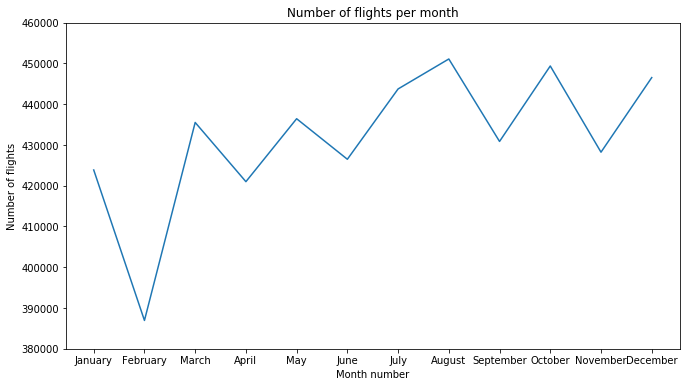

In [22]:
import matplotlib.pyplot as plt

numberOfFlights=[]
months=['January','February','March','April','May','June','July','August','September','October','November','December']
for i in df.groupBy(df.month).count().orderBy('month', ascending=1).collect():
    numberOfFlights.append(i[1])


plt.figure(num=None, figsize=(11, 6))
plt.plot(months,numberOfFlights)
plt.xticks(months)
axes = plt.gca()
axes.set_ylim([380000,460000])
plt.xlabel("Month number")
plt.ylabel("Number of flights")
plt.title("Number of flights per month")
plt.show()

<div class="alert alert-success">
<b> We can clearly observe that the number of flights increases during the summer months and reaches its maximum in August and during the holidays (in fact the second and third maximum values are in October and December).Added to that , we can see that the month with the least flights is February .<b>
    </div>

### Question 3.2: 

<div class="alert alert-info">
Is there any relationship between the number of flights and the days of the week?  

Plot a bar chart and interpret the figure.

<br>
<br>
<strong>NOTE:</strong> You should study both global aggregates (irrespectively of the month of the year), and monthly aggregates (day statistics, for each different month of the year).

<br>
<br>
By answering this question, we could learn about the importance of the weekend/weekday feature for our predictive task.
</div>

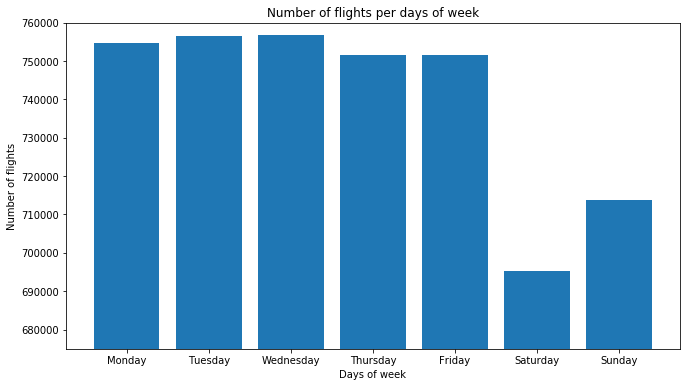

In [23]:
#global aggregates

import matplotlib.pyplot as plt
npd = df.groupBy(df.day_of_week).count().orderBy('day_of_week', ascending=1).collect()

numberOfFlights1=[]
days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
for i in npd:
    numberOfFlights1.append(i[1])

plt.figure(num=None, figsize=(11, 6))
plt.bar(days,numberOfFlights1)
plt.xticks(days)
axes = plt.gca()
axes.set_ylim([675000,760000])
plt.xlabel("Days of week")
plt.ylabel("Number of flights")
plt.title("Number of flights per days of week")
plt.show()

#### Comment:  
<div class="alert alert-success">
    <b>The number of flights during weekend (Saturday & Sunday) are less compared to the rest of the week, during which, the  flights frequencies are more or less equal.<b>
</div>

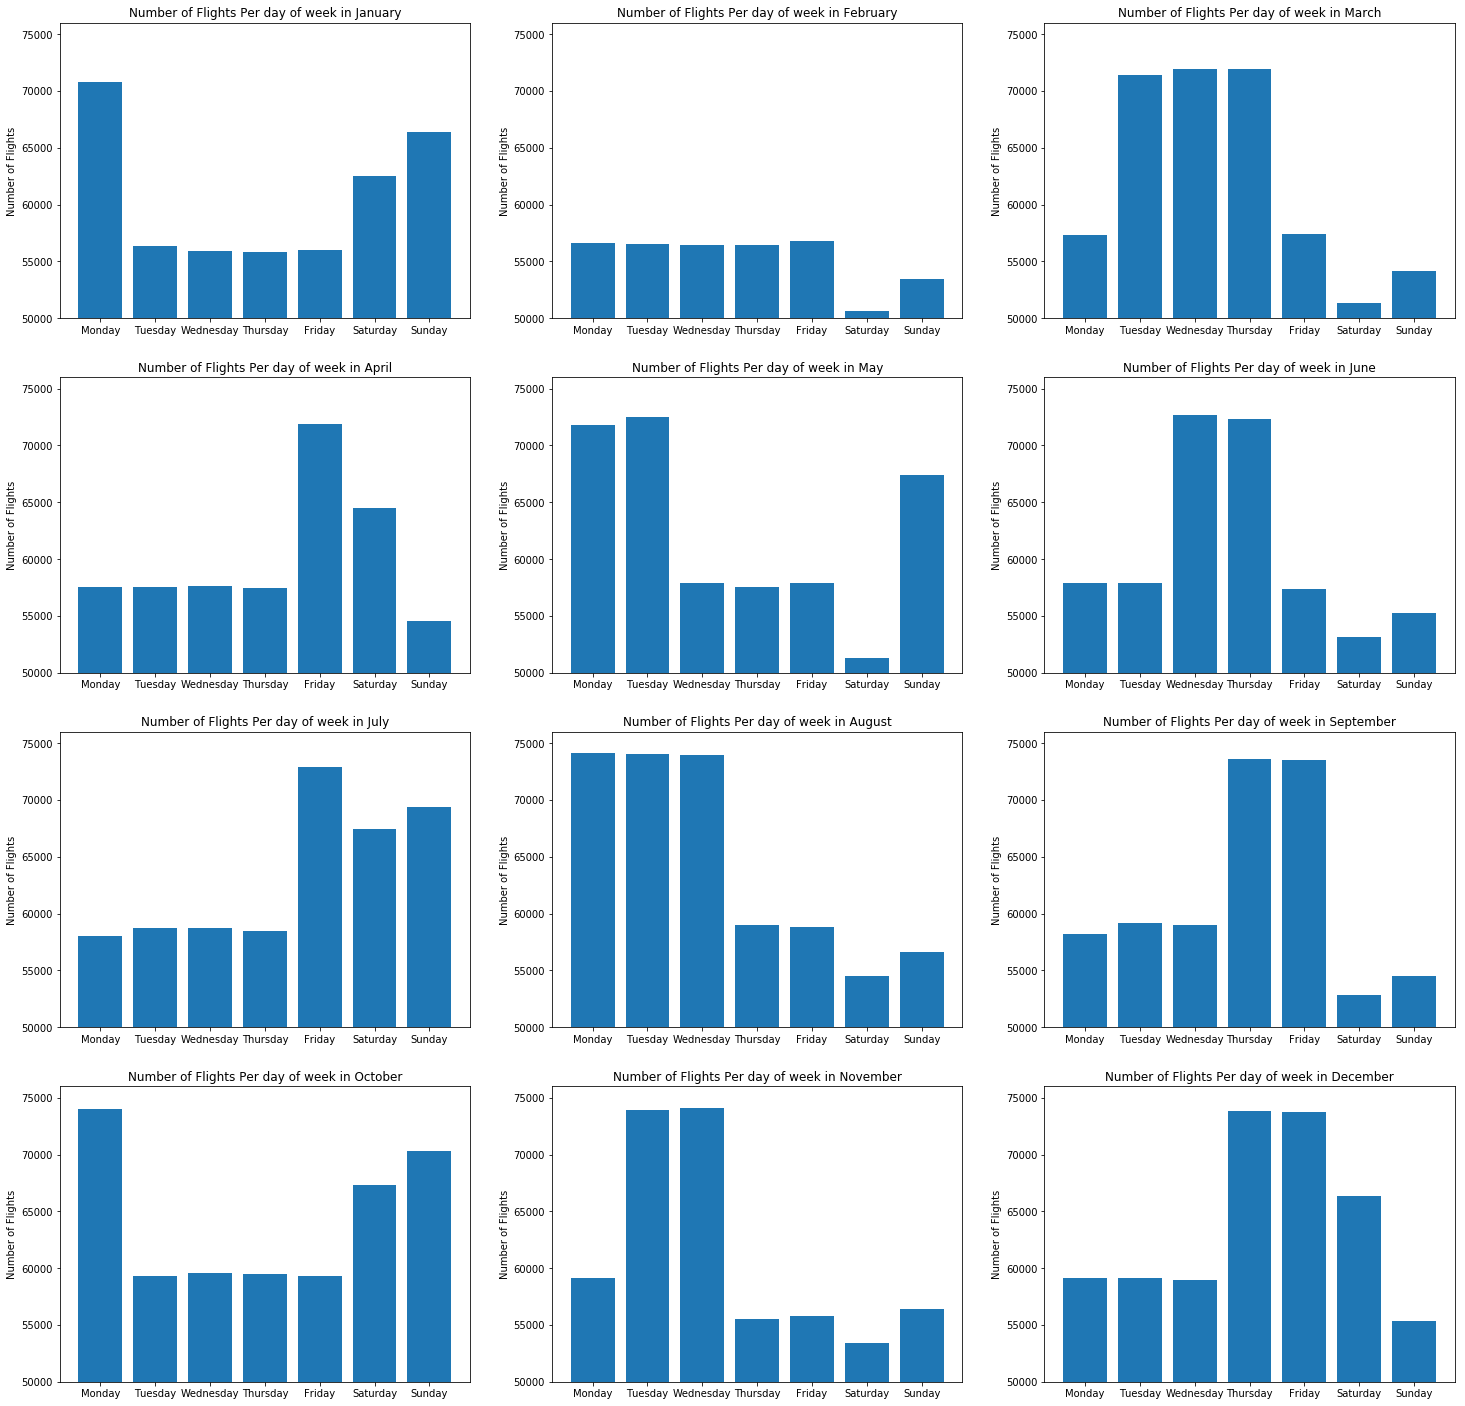

In [24]:
### display 3 months in each row
#monthly aggregates
nRow = 4
nColumn = 3
plt.figure(figsize=(25, 25))
for i in range(12):
    plt.subplot(nRow, nColumn, i+1)
    #count number of flights per day of week for monthly aggregates
    flights_per_day_of_week = df[df.month == (i + 1)].groupBy("day_of_week").count().collect()
    count = [item[1] for item in flights_per_day_of_week]
    day_of_week = [item[0] for item in flights_per_day_of_week]
    
    #plot data
    plt.bar(day_of_week, count, align="center")
    plt.xticks(day_of_week, [days[(_ - 1)] for _ in day_of_week])
    axes = plt.gca()
    axes.set_ylim([50000,76000])
    plt.xlabel("", fontsize = 10)
    plt.ylabel("Number of Flights")
    plt.title("Number of Flights Per day of week in " + months[i])
plt.show()

<div class="alert alert-success">
   <b> Now, using the monthly aggregates, we can conclude that our previous conclusion is not true for all months.
In August, the first half of the week registers a number of flights way higher compared to the second half. This could happen because in that month people are used to take longer holidays, so they prefer to travel at the beginning of the week. While the reverse trend is registered in others months, in particular during the winter (October, December and January), where people are most likely to travel during the weekend.<b>
</div>

### Question 3.3

<div class="alert alert-info">
How many flights in different days of months and in different hours of days?  
<br>
<br>

<strong>NOTE:</strong> Similarly to the previous note, you need to compute both global statistcs and monthly statistics.

<br>
<br>
Plot  bar charts, and interpret your figures.
</div>

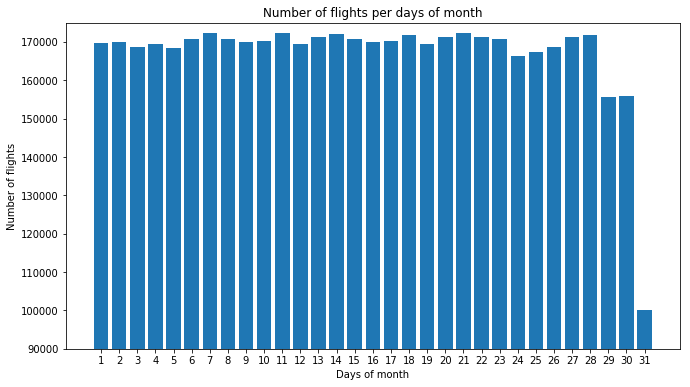

In [25]:
#global aggregates

flights_per_day_of_month=df.groupBy(df.day_of_month).count().orderBy('day_of_month', ascending=1).collect()

numberOfFlights2=[]
days=[]
for i in flights_per_day_of_month:
    days.append(i[0])
    numberOfFlights2.append(i[1])

plt.figure(num=None, figsize=(11, 6))
plt.bar(days,numberOfFlights2)
plt.xticks(days)
axes = plt.gca()
axes.set_ylim([90000,175000])
plt.xlabel("Days of month")
plt.ylabel("Number of flights")
plt.title("Number of flights per days of month")
plt.show()

#### Comment: 
<div class="alert alert-success">
   <b> From the global aggregate above, the number of flights during days of the month do not change a lot(more or less equal) except for the 3 last days, during which the number of flights of days 29 and 30 are less and equal, for the last day 31st, the number of flights is very less compared to other days.(because not all months has a 31th day ). <b>
</div>

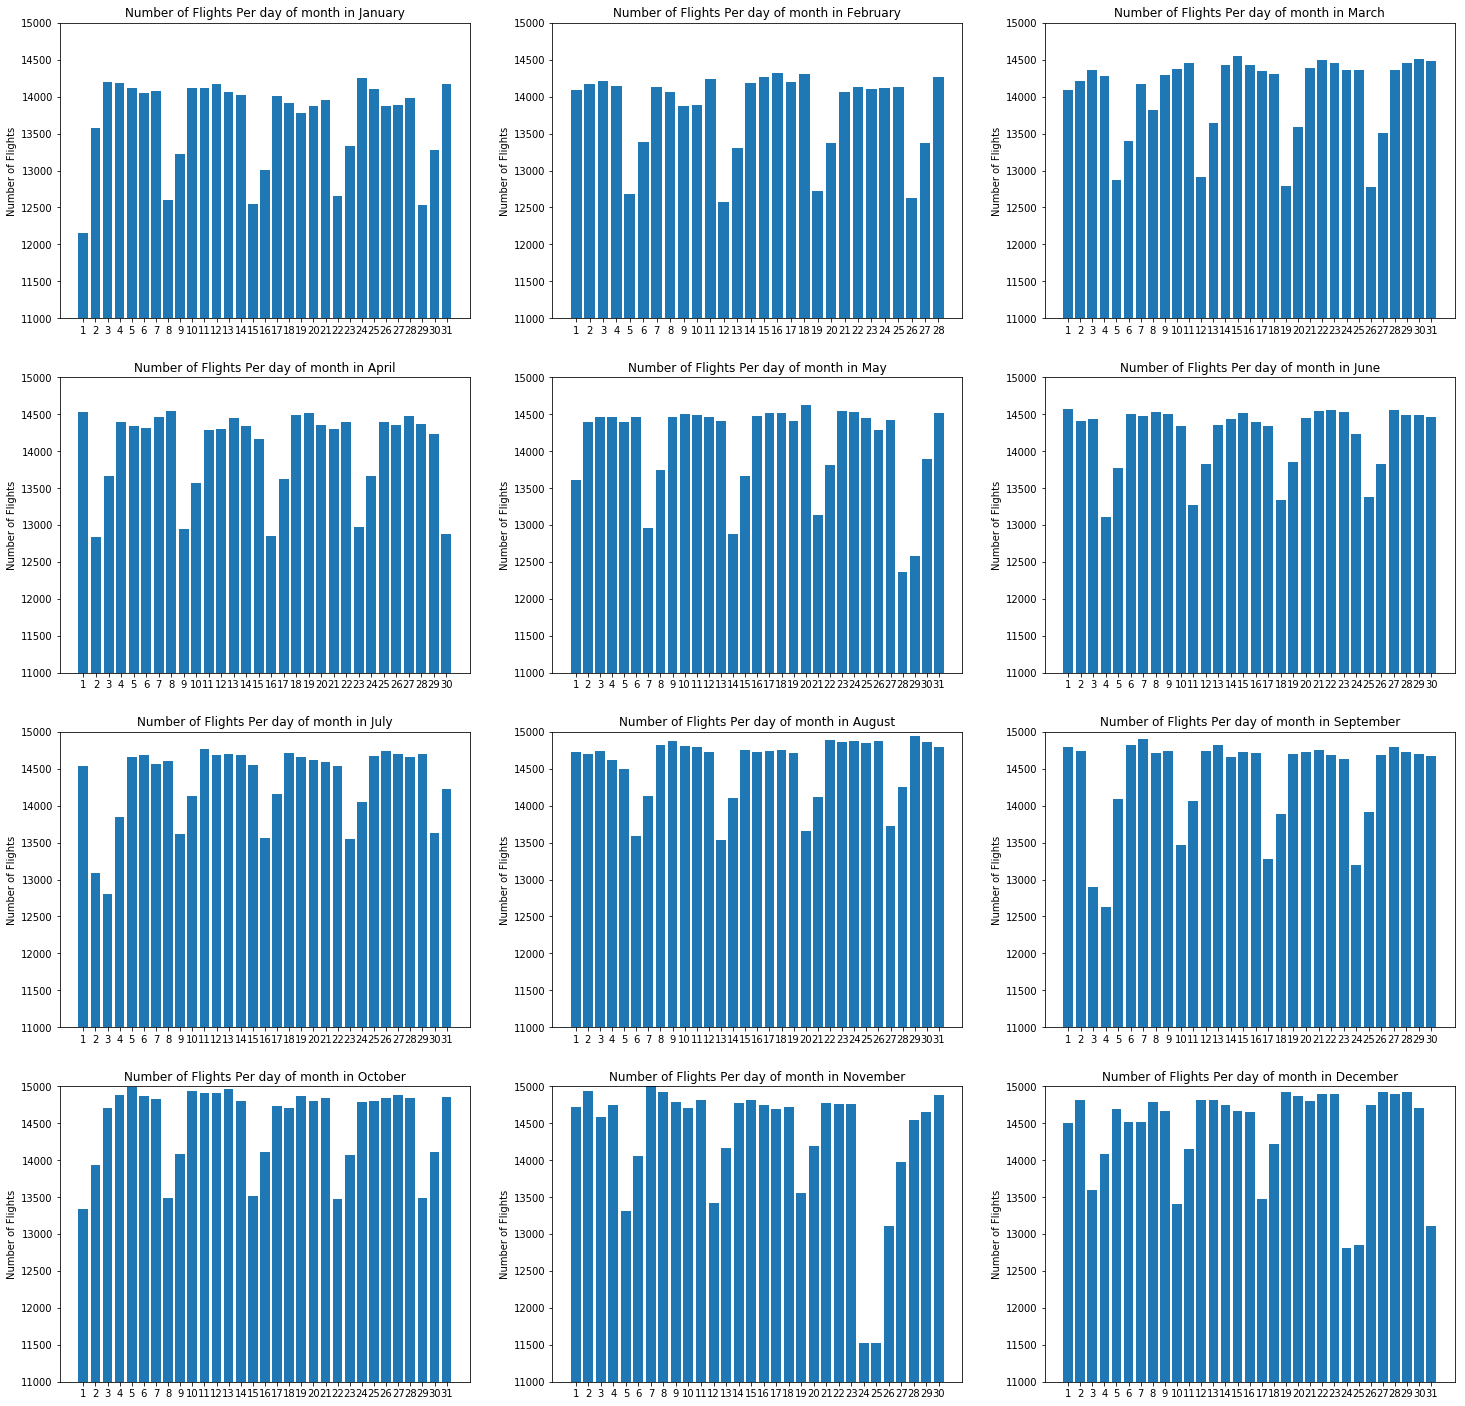

In [26]:
#monthly aggregates

nRow = 4
nColumn = 3
plt.figure(figsize=(25, 25))
for i in range(12):
    plt.subplot(nRow, nColumn, i+1)
    flights_per_day_of_month = df[df.month == (i + 1)].groupBy("day_of_month").count().collect()
    count = [item[1] for item in flights_per_day_of_month]
    days = [item[0] for item in flights_per_day_of_month]
    
    #plot data
    plt.bar(days, count, align="center")
    plt.xlabel("", fontsize = 10)
    plt.ylabel("Number of Flights")
    plt.title("Number of Flights Per day of month in " + months[i])
    plt.ylim([11000,15000])
    plt.xticks(days)
plt.show()

#### Comment: 
<div class="alert alert-success">
    <b> We can observe that during the US holidays , the number of flights is less then the monthly average, while an increment is registered in the days right before or after , that could be explained by the increase of traveling in order to meet friends or family.Furthermore,we can clearly observe the clients behaviour during the holidays: for example during Christmas (24-25 December), or at the end of the year (31 December), or during the Thanksgiving day (4th Thursday of November: 24), the number of flights is less respect to the montly average.
Moreover, our plot confirms what we have seen from the previouse one: the "monthly trend" oscillate depending on the day of the week!<b>
</div>

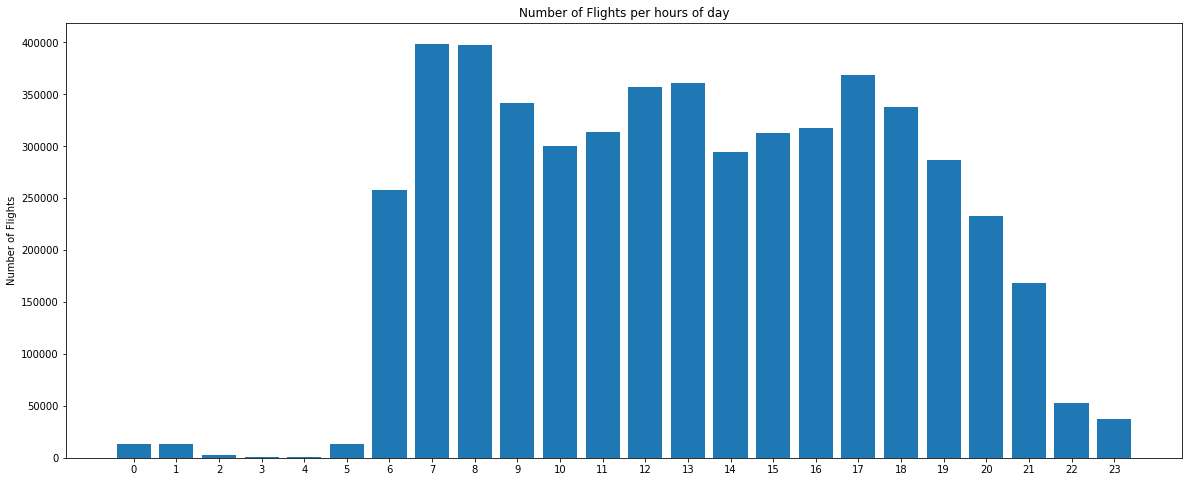

In [57]:
# Global aggregate: 
# flights in different hours of day 
#scheduled_departure_time converted to hours
flights_per_hour_of_day = (df.groupBy(((df.scheduled_departure_time/100).cast('int')%24).alias('hours')).count().orderBy('hours').collect())
count = [item[1] for item in flights_per_hour_of_day]
hours_of_day = [item[0] for item in flights_per_hour_of_day]
#plot data
plt.figure(figsize=(20,8))
plt.bar(hours_of_day, count, align="center")
plt.ylabel("Number of Flights")
plt.title("Number of Flights per hours of day")
plt.xticks(hours_of_day)
plt.show()

#### Comment:
<div class="alert alert-success">
   <b> The number of flights are highest between 7 and 8 am(~ 400,000/h), are less high from 9am to 7pm, and become slightly low decreasing starting from 8pm.
    From 2am to 4am, number of flights is very low compared to the rest of the day.<b>
</div>

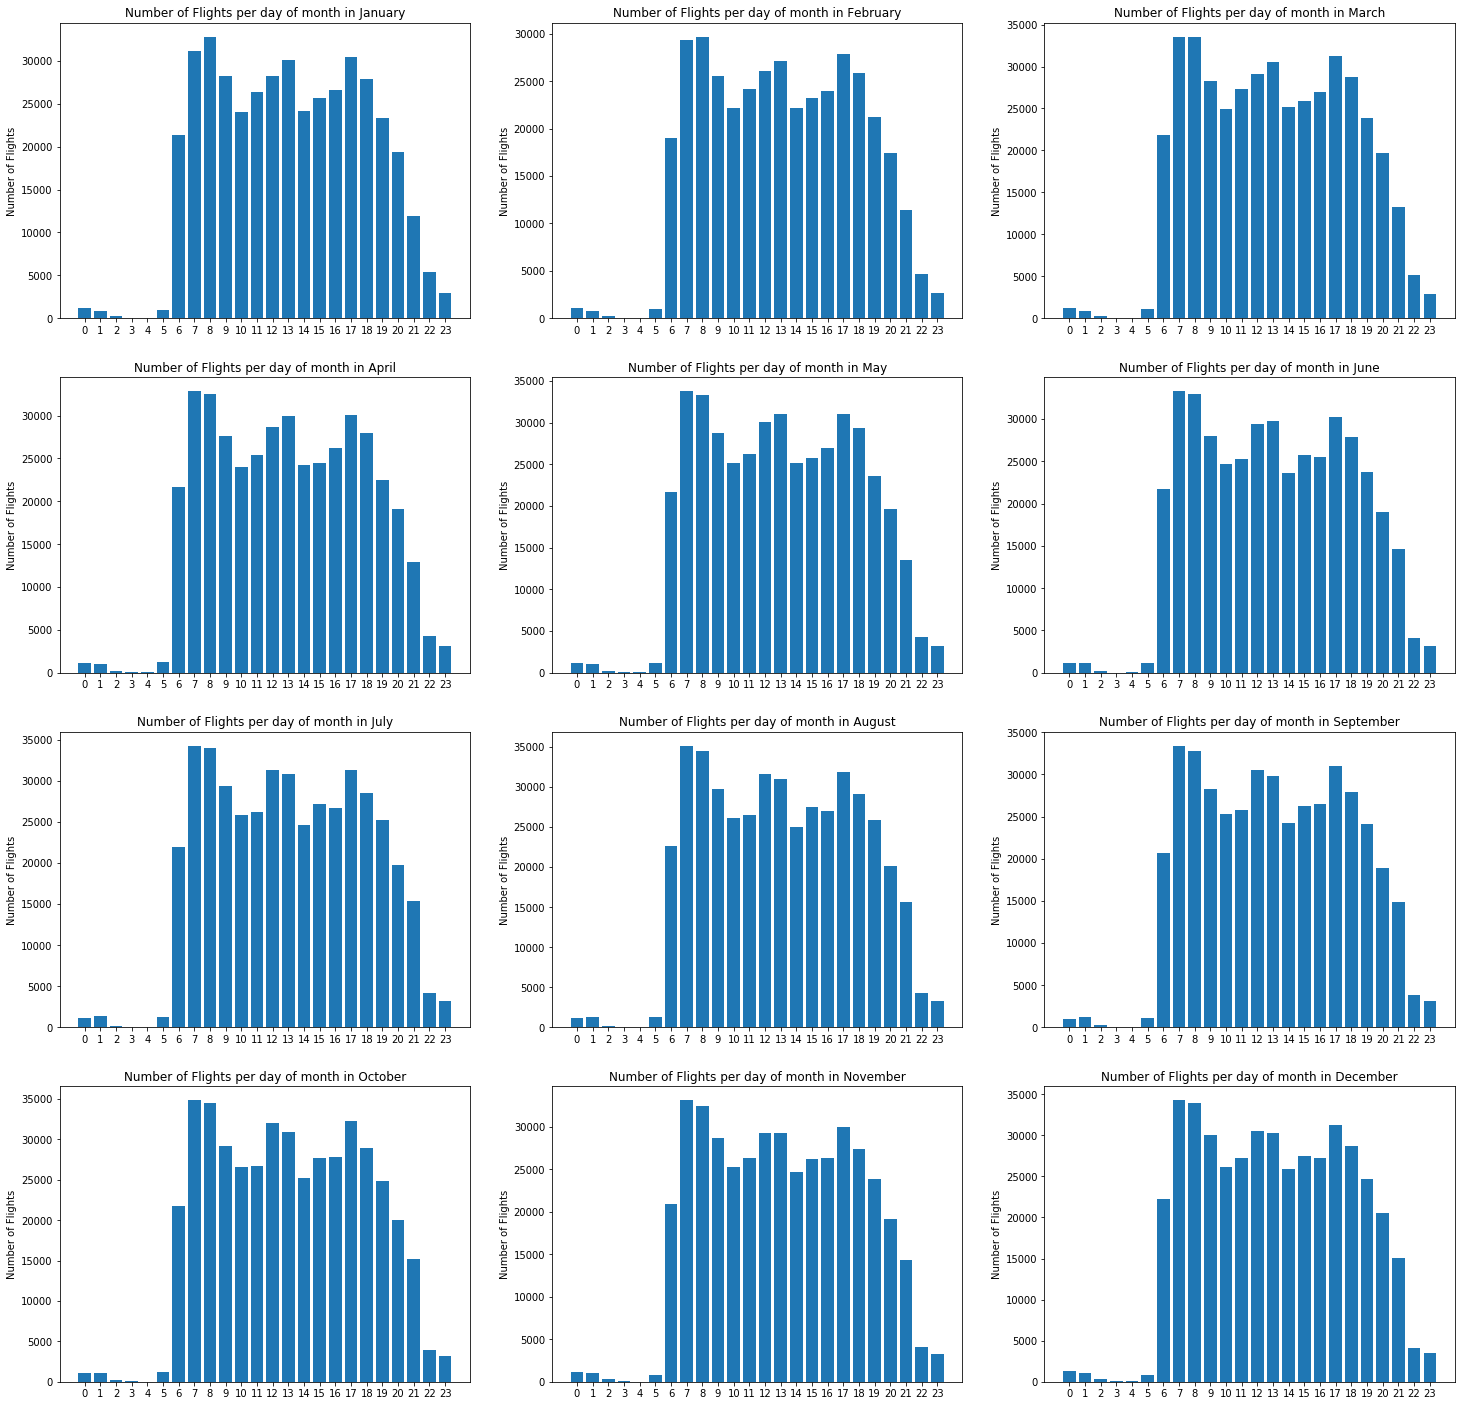

In [58]:
# Monthly aggregates: 
nRow = 4
nColumn = 3
plt.figure(figsize=(25, 25))
for i in range(12):
    plt.subplot(nRow, nColumn, i+1)
    flights_per_hour_of_day = (df[df.month == (i + 1)].groupBy(((df.scheduled_departure_time/100).cast('int')%24).alias('hours'))
    .count().orderBy('hours').collect())
    count = [item[1] for item in flights_per_hour_of_day]
    hours_of_day = [item[0] for item in flights_per_hour_of_day]
    
    #plot data
    plt.bar(hours_of_day, count, align="center")
    plt.xlabel("", fontsize = 10)
    plt.ylabel("Number of Flights")
    plt.title("Number of Flights per day of month in " + months[i])
    plt.xticks(hours_of_day)
plt.show()

#### Comment:

<div class="alert alert-success">
<b>From the monthly aggregates above, we can confirm the conclusions from the global aggregate.Since there is a huge difference between the number of flights of (22h-5h) and the rest hours of the day , there is a possiblity that the flight delay in (22h-5h) is less than in the rest hours of the day , however , it still just guessing until we exploit the arrival delay_attribute .<b>
</div>

### Question 3.4

<div class="alert alert-info">
Which are the **top 20** busiest airports? Compute this in terms of the inbound, outbound and total number of flights.
</div>

In [27]:
# Top 20 Busiest airports (inbound):
df.groupBy(df.dest_airport).count().orderBy('count', ascending=0).head(20)

[Row(dest_airport='ORD', count=283720),
 Row(dest_airport='DFW', count=260249),
 Row(dest_airport='ATL', count=221588),
 Row(dest_airport='LAX', count=152959),
 Row(dest_airport='STL', count=152800),
 Row(dest_airport='DEN', count=144099),
 Row(dest_airport='PHX', count=140979),
 Row(dest_airport='DTW', count=139435),
 Row(dest_airport='PIT', count=131962),
 Row(dest_airport='CLT', count=130321),
 Row(dest_airport='MSP', count=124758),
 Row(dest_airport='SFO', count=117245),
 Row(dest_airport='EWR', count=117223),
 Row(dest_airport='IAH', count=104409),
 Row(dest_airport='LGA', count=101498),
 Row(dest_airport='BOS', count=99331),
 Row(dest_airport='LAS', count=94948),
 Row(dest_airport='PHL', count=93312),
 Row(dest_airport='DCA', count=87670),
 Row(dest_airport='MCO', count=76600)]

In [28]:
# Top 20 Busiest airports (outbound):
df.groupBy(df.src_airport).count().orderBy('count', ascending=0).head(20)

[Row(src_airport='ORD', count=277741),
 Row(src_airport='DFW', count=256274),
 Row(src_airport='ATL', count=221486),
 Row(src_airport='LAX', count=153494),
 Row(src_airport='STL', count=151609),
 Row(src_airport='DEN', count=141427),
 Row(src_airport='PHX', count=139581),
 Row(src_airport='DTW', count=136837),
 Row(src_airport='PIT', count=130977),
 Row(src_airport='CLT', count=129391),
 Row(src_airport='MSP', count=123222),
 Row(src_airport='SFO', count=118233),
 Row(src_airport='EWR', count=116768),
 Row(src_airport='IAH', count=104182),
 Row(src_airport='LGA', count=101864),
 Row(src_airport='BOS', count=100365),
 Row(src_airport='LAS', count=94972),
 Row(src_airport='PHL', count=93585),
 Row(src_airport='DCA', count=88445),
 Row(src_airport='MCO', count=77120)]

In [29]:
# Top 20 Busiest airports (Total number of flights):

df1 = df.withColumn('airport', df.dest_airport).union(df.withColumn('airport', df.src_airport))
df1.groupBy('airport').count().orderBy('count', ascending=0).head(20)

[Row(airport='ORD', count=561461),
 Row(airport='DFW', count=516523),
 Row(airport='ATL', count=443074),
 Row(airport='LAX', count=306453),
 Row(airport='STL', count=304409),
 Row(airport='DEN', count=285526),
 Row(airport='PHX', count=280560),
 Row(airport='DTW', count=276272),
 Row(airport='PIT', count=262939),
 Row(airport='CLT', count=259712),
 Row(airport='MSP', count=247980),
 Row(airport='SFO', count=235478),
 Row(airport='EWR', count=233991),
 Row(airport='IAH', count=208591),
 Row(airport='LGA', count=203362),
 Row(airport='BOS', count=199696),
 Row(airport='LAS', count=189920),
 Row(airport='PHL', count=186897),
 Row(airport='DCA', count=176115),
 Row(airport='MCO', count=153720)]

### Question 3.5
<div class="alert alert-info">
Which are the **top 20** busiest carriers? Compute this in terms of number of flights.
</div>


In [30]:
# Top 20 Busiest carriers
df.groupBy(df.carrier).count().orderBy('count', ascending=0).head(20)

[Row(carrier='DL', count=874526),
 Row(carrier='US', count=857906),
 Row(carrier='AA', count=722277),
 Row(carrier='UA', count=638750),
 Row(carrier='WN', count=565426),
 Row(carrier='CO', count=484834),
 Row(carrier='NW', count=482798),
 Row(carrier='TW', count=258205),
 Row(carrier='HP', count=177851),
 Row(carrier='AS', count=117475)]

## Question 4 
In this series of questions we focus on the computation of statistics about the percentage of delayed flights.

### Question 4.1
<div class="alert alert-info">
What is the percentage of delayed flights for different hours of the day?  

Plot a bar chart and interpret the figure.  


<div class="label label-success">IMPORTANT!</div> A flight is considered as delayed if it's actual arrival time is more than 15 minutes later than the scheduled arrival time.

</div>

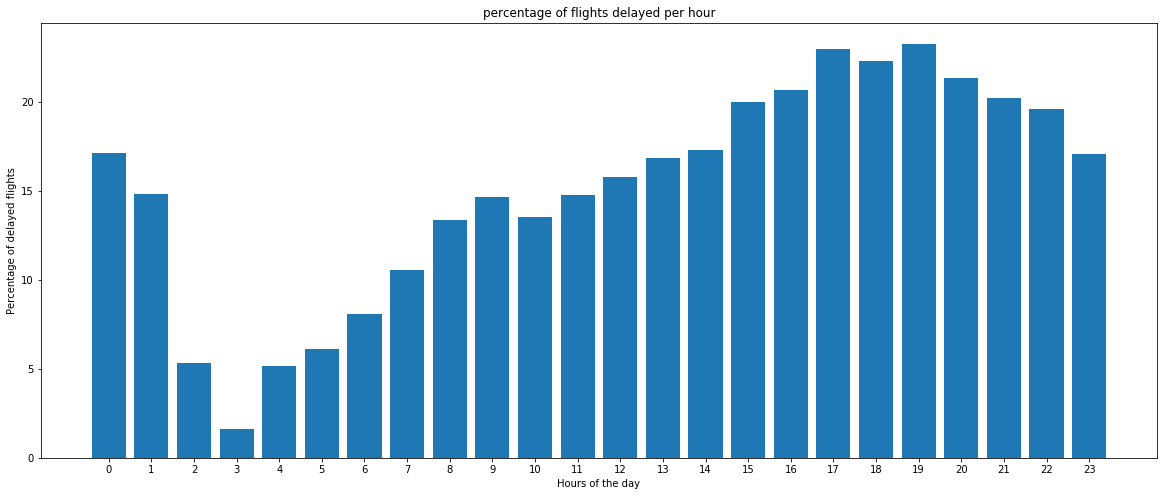

In [31]:
# All flights per hour
all_flights_hour=(df.groupBy(((df.scheduled_departure_time/100).cast('int')).alias('hour'))
    .count().orderBy('hour'))

# Delayed flights per hour
delayed_flights_hour= (df[df.arrival_delay >= 15].groupBy(((df.scheduled_departure_time/100)
    .cast('int')).alias('hour'))
    .count().alias('number_of_flight').orderBy('hour'))



# Percentage of delayed flights per hour:
percentage_delayed_flights_hour = (
    delayed_flights_hour.join(all_flights_hour, delayed_flights_hour.hour == all_flights_hour.hour, 'inner')
    .select(all_flights_hour.hour, delayed_flights_hour['count']*100/all_flights_hour['count'])
    .orderBy('hour')
    .collect()
)

hours=[i[0] for i in percentage_delayed_flights_hour]
percentages=[i[1] for i in percentage_delayed_flights_hour]
plt.figure(figsize=(20,8))

# THABBET MENHA , MANICH SUR §§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§
#pdf_delay_ratio_per_hour=(hours, percentages)

plt.bar(hours, percentages, align="center")
plt.xlabel('Hours of the day')
plt.ylabel("Percentage of delayed flights")
plt.title("percentage of flights delayed per hour")
plt.xticks(hours)
plt.show()

#### Comment:
<div class="alert alert-success">
 <b> As we can see from above, the percentage of delayed flights keep increasing from 4am to 7pm when it reaches a maximum boundary(~28%) and then starts decreasing.
    The least percentage of delayed flights is 2%,between 3 and 4am. This was expected as a consequence of what low number of flights at that time . However , this is not exactly true for all the night flights .In fact, between the 22 and the 2am, despite the amount of flights is not as high as it is at 7am, the probability of delay is still around 0.15 ( relatively high ) .<b>
    
</div>

### Question 4.2
<div class="alert alert-info">
You will realize that saying *"at 4 A.M. there is a very low chance of a flight being delayed"* is not giving you a full picture of the situation. Indeed, it might be true that there is very little probability for an early flight to be delayed, but if it does, the delay might be huge, like 6 hours!  

<ul></ul>

Then, the question is: **which hours of the day are characterized by the largest mean delay?** (you can consider the median too)  

Plot a Bar chart and explain it.  

</div>

With data of year 1994, the flight from 3AM to 4AM often depart earlier than in their schedule. The flights in the morning have less delay then in the afternoon and evening.

So, an attentive student should notice here that we have somehow a problem with the definition of delay! Next, we will improve how to represent and visualize data to overcome this problem.

**NOTE**: the following piece of code assumes you correctly answered the previous questions. The naming convention of the DataFrames we use next should be clear enough for you to produce them by answering the questions above.

In [32]:
# Average number of delayed flights grouped by hour
avg_delayed_per_hour = (
    df.groupBy(((df.scheduled_departure_time/100)%24).cast('int').alias('hour'))
    .avg('arrival_delay')
    .orderBy('hour')
    .collect()
)
tmp1=[i[0] for i in avg_delayed_per_hour]
tmp2=[i[1] for i in avg_delayed_per_hour]

#§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§§
#pdf_delay_ratio_per_hour_tmp=[tmp1,tmp2]
#pdf_mean_delay_per_hour=pdf_delay_ratio_per_hour_tmp

pdf_delay_ratio_per_hour=[tmp1,tmp2]
pdf_mean_delay_per_hour=pdf_delay_ratio_per_hour

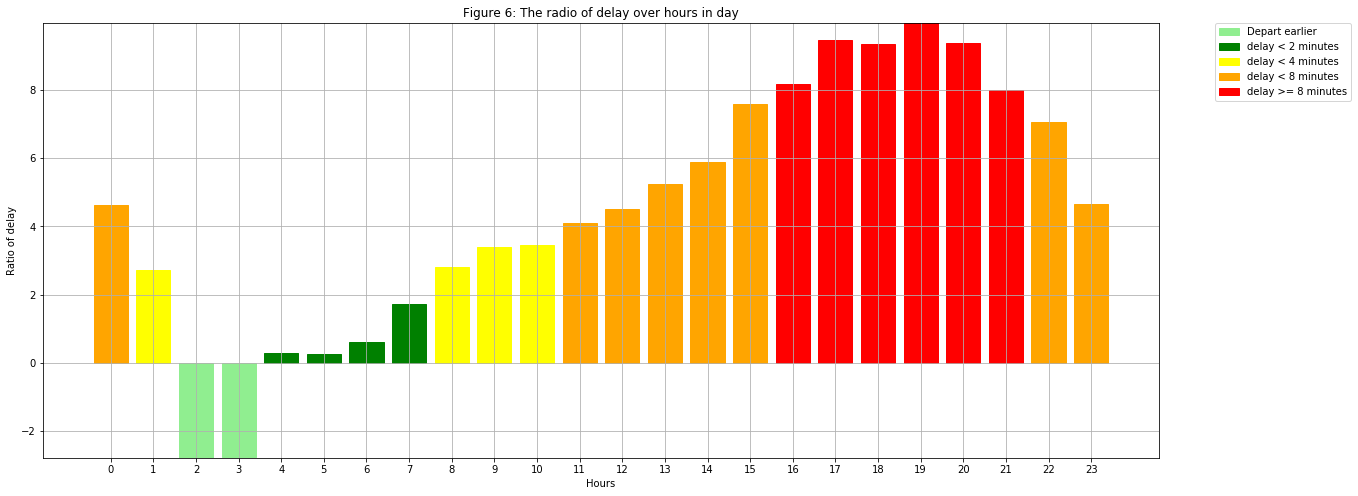

In [35]:
#pdf2 = pd.DataFrame(data=mean_delay_per_hour.collect())
plt.figure(figsize=(20,8))
plt.xlabel("Hours")
plt.ylabel("Ratio of delay")
plt.title('Figure 6: The radio of delay over hours in day')
plt.grid(True,which="both",ls="-")
bars = plt.bar(pdf_delay_ratio_per_hour[0], pdf_delay_ratio_per_hour[1], align='center', edgecolor = "black")
for i in range(0, len(bars)):
    color = 'red'
    if pdf_mean_delay_per_hour[1][i] < 0:
        color = 'lightgreen'
    elif pdf_mean_delay_per_hour[1][i] < 2:
        color = 'green'
    elif pdf_mean_delay_per_hour[1][i] < 4:
        color = 'yellow'
    elif pdf_mean_delay_per_hour[1][i] < 8:
        color = 'orange'

    bars[i].set_color(color)
        
patch1 = mpatches.Patch(color='lightgreen', label='Depart earlier')
patch2 = mpatches.Patch(color='green', label='delay < 2 minutes')
patch3 = mpatches.Patch(color='yellow', label='delay < 4 minutes')
patch4 = mpatches.Patch(color='orange', label='delay < 8 minutes')
patch5 = mpatches.Patch(color='red', label='delay >= 8 minutes')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xticks([p for p in range(len(avg_delayed_per_hour))], [p for p in range(len(avg_delayed_per_hour))])
plt.margins(0.05, 0)
plt.show()

#### Comment:
<div class="alert alert-success">
<b>In the new figure (Figure 6), we have more information in a single plot. The flights between 3AM to 6AM have very low probability of being delayed, flights between 2AM and 3 AM have a negative arrival delay that means that the flight landed earlier than it's supposed to land . In contrast, the flights in the 4PM to 8PM range have higher chances of being delayed: in more than 50% of the cases, the delay is 8 minutes or more.<br>
This example shows us that the way representing results are also important.
<b>
</div>

### Question 4.3

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a month. Discuss your findings from the figure.
</div>

+------------+------------------+
|day_of_month|       delay_ratio|
+------------+------------------+
|           1|14.879121138182633|
|           2|15.071630875763267|
|           3|14.854337850816348|
|           4|14.438692082007568|
|           5| 16.99233477612915|
|           6| 16.37503662467038|
|           7|16.580918645839382|
|           8|16.666861970774693|
|           9|18.872040311153185|
|          10|18.175997932476566|
|          11|14.892493705109015|
|          12| 16.77401469842281|
|          13|17.829819540968288|
|          14| 16.84439304746021|
|          15|17.487129327562275|
|          16|17.532135188398975|
|          17|16.995039146074813|
|          18| 17.34179719319478|
|          19|14.538331278063287|
|          20| 17.57137347933295|
+------------+------------------+
only showing top 20 rows



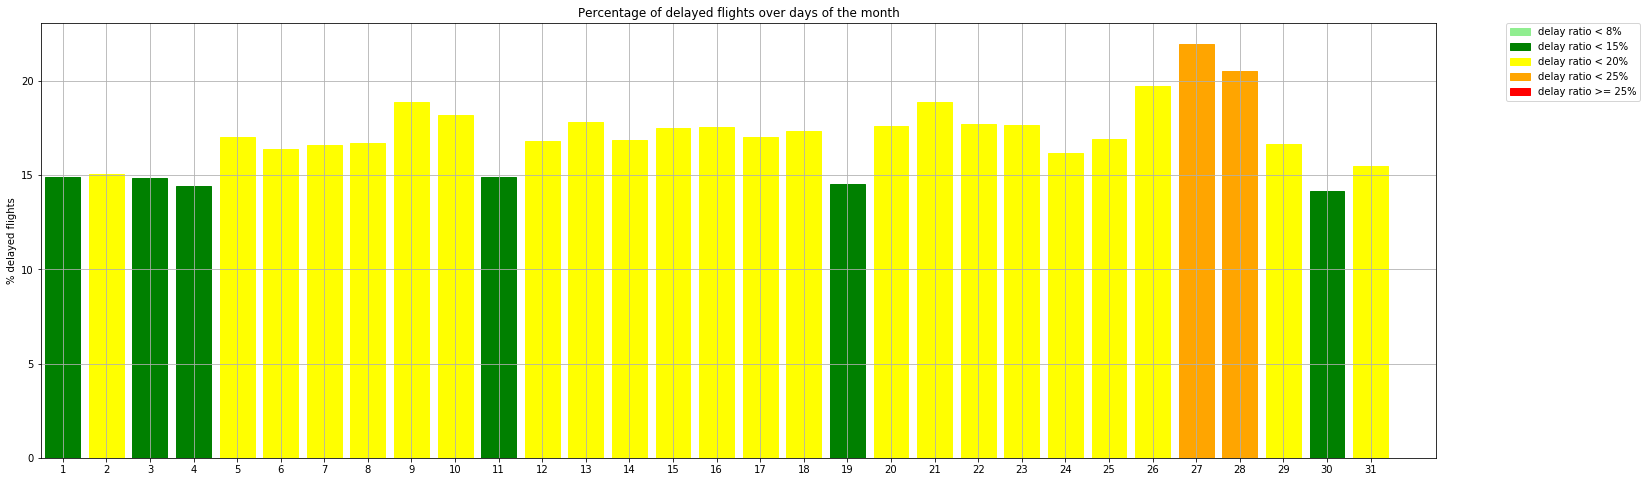

In [41]:
# to compute the delayed flights we create a new dataframe which is the result of the df_hour_day + one additional column:
# 'is_delay' is a column with 'boolean' values: 
# 1 to signal that the flight is in delay (arrived more then 15 minutes later)
# 0 otherwise
df_with_delay = df.withColumn('is_delay', func.when(df["arrival_delay"] >= 15, 1).otherwise(0))


# QUERY
# for each day of month (group by day of month) we aggregate the percentage of delays, which is computed as the 
# count of all the flights with the 'is_delay' column set to 1, divided by the total number of rows in the group.
statistic_day = df_with_delay.groupBy(['day_of_month'])\
                 .agg((100*func.sum('is_delay')/func.count('*')).alias('delay_ratio'))\
                 .orderBy('day_of_month')


# PRINT & COLLECT
statistic_day.show()
delay_day_of_month = statistic_day.collect()


# PLOT
plt.figure(figsize=(25,8))
bars = plt.bar([x for x in range(len(delay_day_of_month))], [x[1] for x in delay_day_of_month])
for j in range(0, len(bars)):
    color = 'red'
    if delay_day_of_month[j][1] < 8:
        color = 'lightgreen'
    elif delay_day_of_month[j][1] < 15:
        color = 'green'
    elif delay_day_of_month[j][1] < 20:
        color = 'yellow'
    elif delay_day_of_month[j][1] < 25:
        color = 'orange'
    bars[j].set_color(color)
patch1 = mpatches.Patch(color='lightgreen', label='delay ratio < 8%')
patch2 = mpatches.Patch(color='green', label='delay ratio < 15%')
patch3 = mpatches.Patch(color='yellow', label='delay ratio < 20%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 25%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 25%')
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('% delayed flights')
plt.title('Percentage of delayed flights over days of the month')
plt.xticks([x for x in range(31)], [x+1 for x in range(31)])
plt.xlim(0-0.5, 31+0.5)

plt.grid()
plt.show()


#### Comment:
<div class="alert alert-success">
   <b> In general the gap between delay percentages during days of month is not big(min: 14.5%, max: 23%).
    The flights of the begining and the end of the month are less likely to be delayed.
    There is somekind of periodic change, on days 11, 19 & 30, flights have the least percentage of getting delayed.<b>
</div>

### Question 4.4

<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over days in a week. Discuss your findings from the figure.
</div>

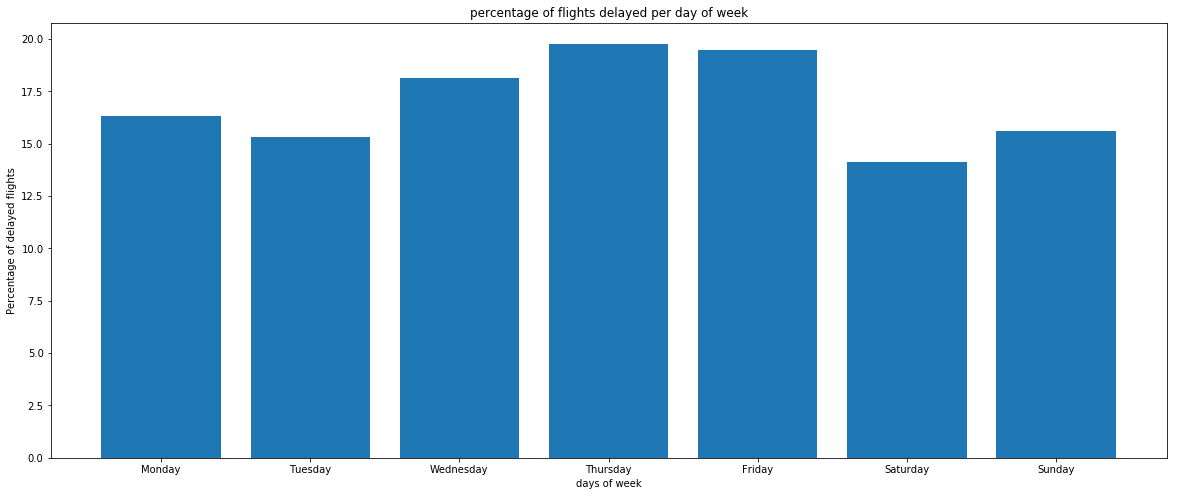

In [42]:
# All flights per day of week
all_flights_day_of_week=df.groupBy(df.day_of_week).count()

# Delayed flights per day of week
delayed_flights_day_of_week= df[df.arrival_delay >= 15].groupBy(df.day_of_week).count()



# Percentage of delayed flights per day of week:
percentage_delayed_flights_day_of_week = (
    delayed_flights_day_of_week.join(all_flights_day_of_week, delayed_flights_day_of_week.day_of_week == all_flights_day_of_week.day_of_week, 'inner')
    .select(all_flights_day_of_week.day_of_week, delayed_flights_day_of_week['count']*100/all_flights_day_of_week['count'])
    .orderBy('day_of_week')
    .collect()
)

#day_of_week=[i[0] for i in percentage_delayed_flights_day_of_week]
days=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
day_of_week=[str(i) for i in days]
percentages=[i[1] for i in percentage_delayed_flights_day_of_week]
plt.figure(figsize=(20,8))

plt.bar(day_of_week, percentages, align="center")
plt.xlabel('days of week')
plt.ylabel("Percentage of delayed flights")
plt.title("percentage of flights delayed per day of week")
plt.xticks(day_of_week)
plt.show()

### Comment:
<div class="alert alert-success">
  <b>  The higher percentages that the flight gets delayed are on days: Wednesday,Thursday & Friday.
    During the weekend, flights are less likely to get delayed. This was expected because the number of flights during the weekend was lower then during the others day of the week.<br>
    In general, all flights during all days of the week have less than 20% to get delayed.<b>
</div>

### Question 4.5
<div class="alert alert-info">
Plot a bar chart to show the percentage of delayed flights over months in a year. Discuss your findings from the figure.
</div>

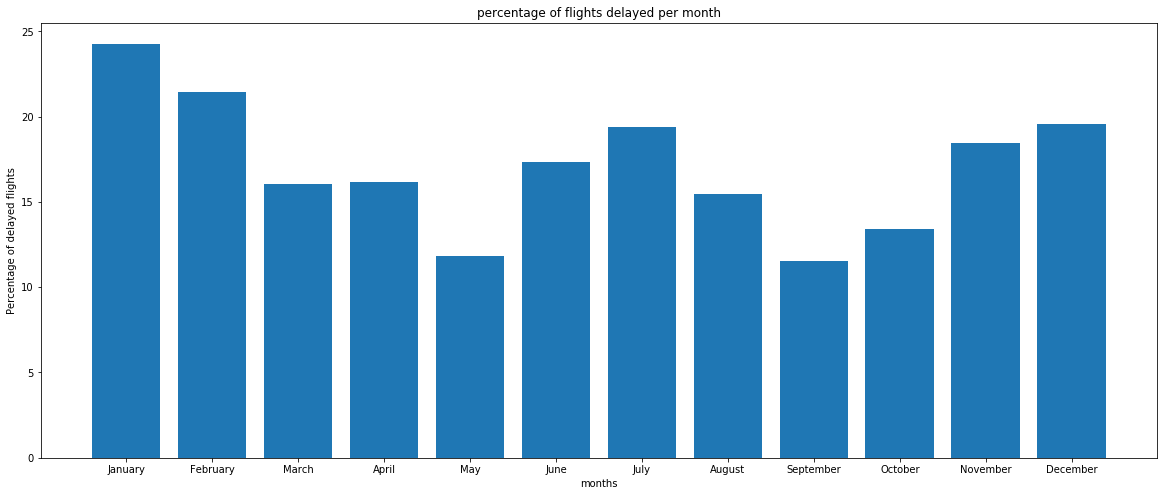

In [45]:
# All flights per month of the year
all_flights_month=df.groupBy(df.month).count()

# Delayed flights per month
delayed_flights_month= df[df.arrival_delay >= 15].groupBy(df.month).count()



# Percentage of delayed flights per month:
percentage_delayed_flights_month = (
    delayed_flights_month.join(all_flights_month, delayed_flights_month.month == all_flights_month.month, 'inner')
    .select(all_flights_month.month, delayed_flights_month['count']*100/all_flights_month['count'])
    .orderBy('month')
    .collect()
)

months_n = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
months=[i[0] for i in percentage_delayed_flights_month]
percentages=[i[1] for i in percentage_delayed_flights_month]
plt.figure(figsize=(20,8))

plt.bar(months, percentages, align="center")
plt.xlabel('months')
plt.ylabel("Percentage of delayed flights")
plt.title("percentage of flights delayed per month")
plt.xticks(months,months_n)
plt.show()

### Comments:
<div class="alert alert-success">
   <b> - The values of delay percentages belongs to [12%,24%] and they vary clearly from a month to the other.
    <br>
    - The higher percentages for a flight delay are on: January & February . There is a possiblity that this could be explaines by the weather conditions in the winter months .
    <br>
    - The least percentages are on: May & September. <b>
</div>

We are ready now to draw some observations from our data, even if we have only looked at data coming from a year worth of flights:

- The probability for a flight to be delayed is low at the beginning or at the very end of a given months
- Flights on two first weekdays and on the weekend, are less likely to be delayed
- May and September are very good months for travelling, as the probability of delay is low (remember we're working on US data. Do you think this is also true in France?)

Putting things together, we can have a global picture of the whole year!

In [46]:
df_with_delay = df.withColumn('is_delay', func.when(df["arrival_delay"] >= 15, 1).otherwise(0))
statistic_day = df_with_delay.groupBy(['year','month', 'day_of_month', 'day_of_week'])\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'))

# assume that we do statistic on year 1994
statistic_day = statistic_day\
    .orderBy('year', 'month', 'day_of_month', 'day_of_week')
pdf = pd.DataFrame(data=statistic_day.collect())

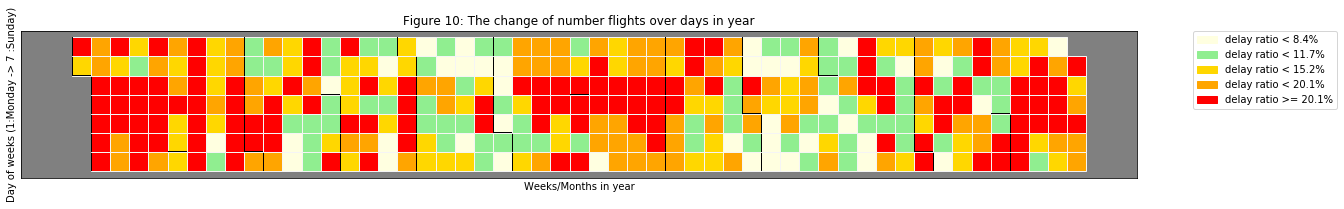

In [47]:
fig = plt.figure(figsize=(20,10))                                                             
ax = fig.add_subplot(1,1,1)     
plt.xlabel("Weeks/Months in year")
plt.ylabel("Day of weeks (1:Monday -> 7 :Sunday)")
plt.title('Figure 10: The change of number flights over days in year')
  
rec_size = 0.3
from matplotlib.patches import Rectangle
import datetime
num_days = len(pdf[0])
ax.patch.set_facecolor('gray')
ax.set_aspect('equal', 'box')
ax.xaxis.set_major_locator(plt.NullLocator())
ax.yaxis.set_major_locator(plt.NullLocator())

for i in range(0, num_days):
    # extract information from the result
    year = pdf[0][i]
    month = pdf[1][i]
    day_of_month = pdf[2][i]
    day_of_week = pdf[3][i]
    day_of_year= datetime.date(year=year, month=month, day=day_of_month).timetuple()
    week_of_year = datetime.date(year=year, month=month, day=day_of_month).isocalendar()[1]
    
    # dealing with the week of the previous year
    if week_of_year == 52 and month == 1:
        week_of_year = 0
        
    # the coordinate of a day in graph
    X = week_of_year*rec_size
    Y = day_of_week*rec_size
    
    # use different colors to show the delay ratio
    color = 'white'
    if pdf[4][i] <= 0.084:
        color = 'lightyellow'
    elif pdf[4][i] <= 0.117:
        color = 'lightgreen'
    elif pdf[4][i] <= 0.152:
        color = 'gold'
    elif pdf[4][i] <= 0.201:
        color = 'orange'
    else:
        color = 'red'
    rect = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, rec_size,
                      alpha=1, facecolor=color, edgecolor='whitesmoke')

    ax.add_patch(rect)
    
    # drawing boders to separate months
    if day_of_month <= 7:
        rect2 = plt.Rectangle((X -rec_size/2.0, Y - rec_size/2.0), 0.01, rec_size,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
    if day_of_month == 1:
        rect2 = plt.Rectangle((X - rec_size/2.0, Y - rec_size/2.0), rec_size, 0.01,
                      alpha=1, facecolor='black')
        ax.add_patch(rect2)
ax.autoscale_view()

patch1 = mpatches.Patch(color='lightyellow', label='delay ratio < 8.4%')
patch2 = mpatches.Patch(color='lightgreen', label='delay ratio < 11.7%')
patch3 = mpatches.Patch(color='gold', label='delay ratio < 15.2%')
patch4 = mpatches.Patch(color='orange', label='delay ratio < 20.1%')
patch5 = mpatches.Patch(color='red', label='delay ratio >= 20.1%')

plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### Question 4.6
<div class="alert alert-info">

What is the delay probability for the top 20 busiest airports?  


By drawing the flight volume of each airport and the associated delay probability in a single plot, we can observe the relationship between airports, number of flights and the delay.  

<div class="label label-success">HINT </div>  Function `<df_colum>.isin(<list>)` helps checking whether a value in column belongs to a list.
<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

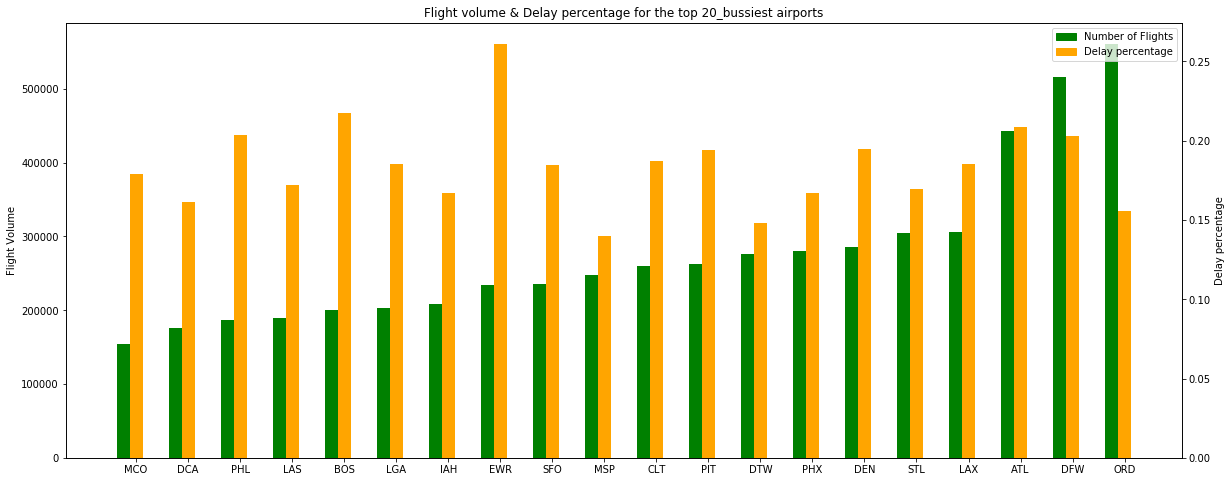

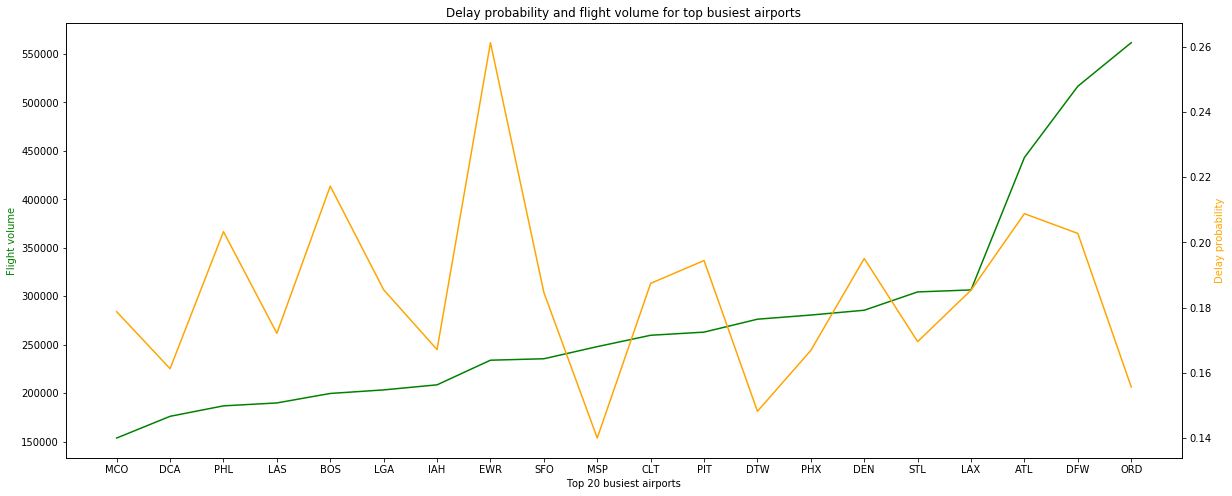

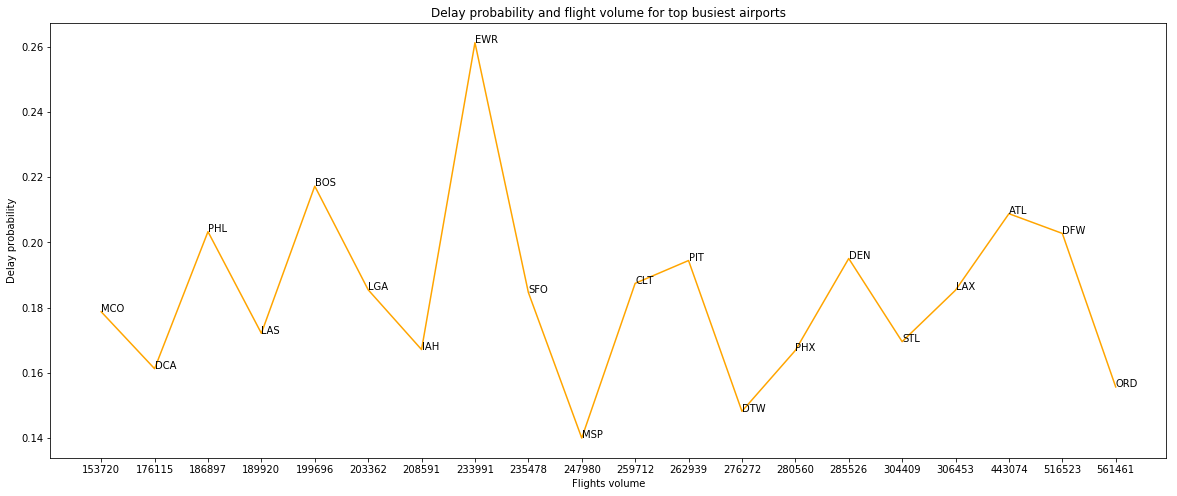

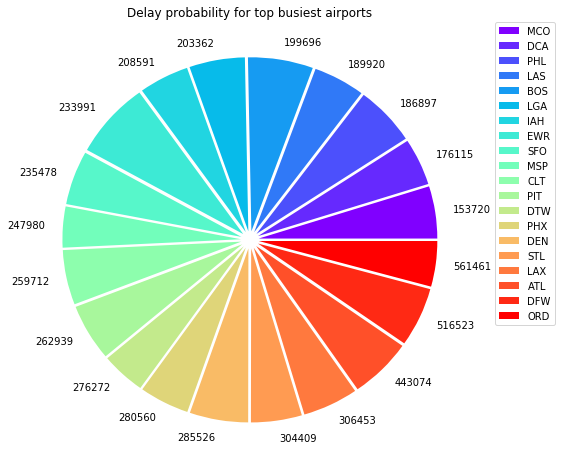

In [67]:
from matplotlib import cm

# Top 20 Busiest airports (Total number of flights):
df1 = df.withColumn('airport', df.dest_airport).union(df.withColumn('airport', df.src_airport)) # Union of all airports
df2 = df1.groupBy('airport').count().orderBy('count', ascending=0)
busiest20_airports=df2.head(20)


# Delay percentage of the 20 busiest airports:
tmp_delay=df1.filter(df1.airport.isin([i[0] for i in busiest20_airports]))
delay_20airports = tmp_delay.withColumn('delay', func.when((df["arrival_delay"]>=15), 1).otherwise(0))
percentage_delay_airport = delay_20airports.groupBy('airport').agg((func.sum('delay')/func.count('*')).alias('delay_percentage')).orderBy('delay_percentage')
# Final df
data = df2.join(percentage_delay_airport, on='airport').select('*').orderBy('count').collect()

fig,ax = plt.subplots(figsize=(20,8))
ax.bar([x for x in range(len(delay_perc_20_airports))], [i[1] for i in delay_perc_20_airports], 0.25, color = 'g')
ax.set_ylabel('Flight Volume')
ax2 = ax.twinx()
bars_delay = (plt.bar([i + 0.25 for i in range(len(delay_perc_20_airports))], 
            [i[2] for i in delay_perc_20_airports], 0.25, color = 'orange'))
ax2.set_ylabel('Delay percentage')

dr_patch = mpatches.Patch(color='g', label='Number of Flights')
nf_patch = mpatches.Patch(color='orange', label='Delay percentage')
plt.legend(handles=[dr_patch,nf_patch])
plt.xticks([i+0.25 for i in range(len(delay_perc_20_airports))], [i[0] for i in delay_perc_20_airports])
plt.title('Flight volume & Delay percentage for the top 20_bussiest airports')



# PLOT (line chart with x=airport, y1=flight volume, y2=delay)
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.set_title('Delay probability and flight volume for top busiest airports')
ax.plot([x for x in range(len(data))], [x[1] for x in data],c='g')
ax.set_xlabel('Top 20 busiest airports')
ax.set_ylabel('Flight volume', color='g')
ax2 = ax.twinx()
ax2.plot([x for x in range(len(data))], [x[2] for x in data], c='orange')
ax2.set_ylabel('Delay probability', color='orange')
plt.xticks([x for x in range(len(data))], [x[0] for x in data])
plt.show()


# PLOT (line chart with x=flight volume and y=delay prob)
plt.figure(figsize=(20,8))
plt.plot([x for x in range(len(data))], [x[2] for x in data],c='orange')
plt.xticks([x for x in range(len(data))], [x[1] for x in data])
for x in range(len(data)):
    plt.annotate('%s' % data[x][0], xy=(x, data[x][2]))
plt.title('Delay probability and flight volume for top busiest airports')
plt.ylabel('Delay probability')
plt.xlabel('Flights volume')
plt.show()

# PLOT (pie chart)
plt.figure(figsize=(8,8))
patches, _ = plt.pie([x[2] for x in data], 
        explode=[0.05 for _ in range(len(data))], 
        colors=cm.rainbow(np.linspace(0, 1, 20)), 
        labels=[x[1] for x in data])
plt.legend(patches, [x[0] for x in data], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Delay probability for top busiest airports')
plt.show()

### Question 4.7

<div class="alert alert-info">
What is the percentage of delayed flights which belong to one of the top 20 busiest carriers?  
Comment the figure!

<ul></ul>
<div class="label label-success">SUGGESTION </div>  You can try with different chart type to have a better visualization.
</div>

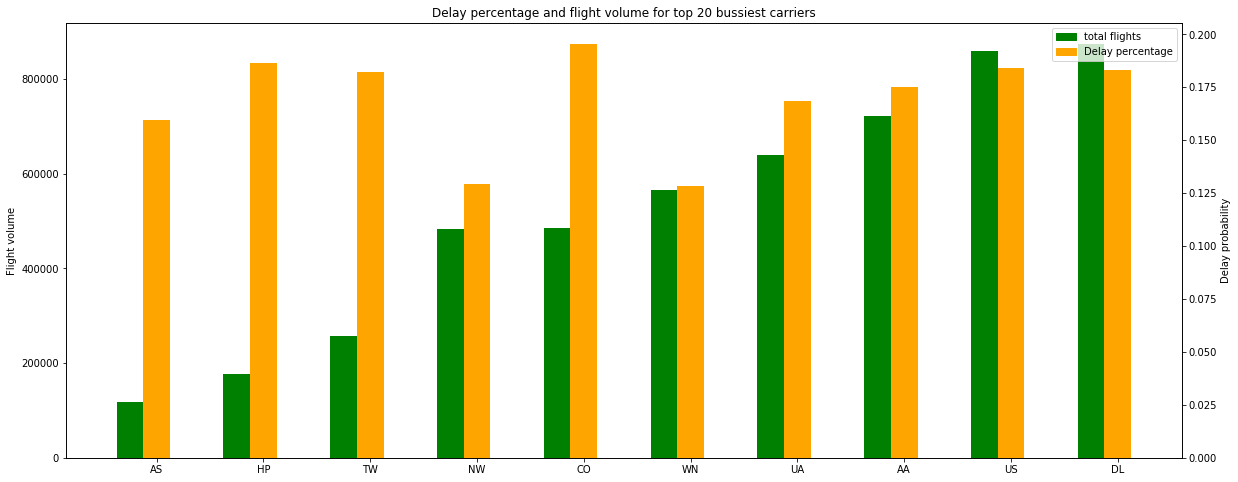

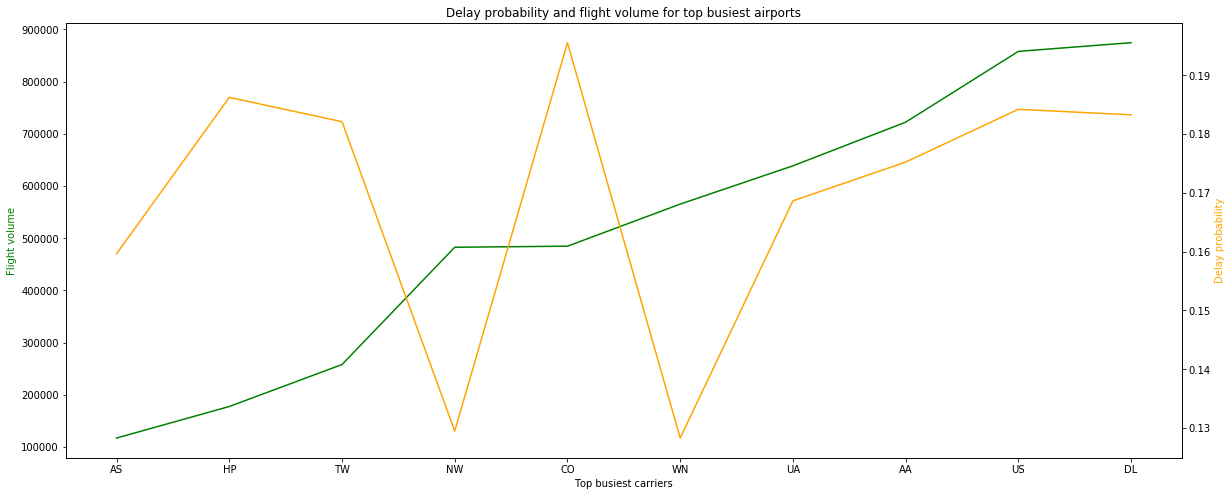

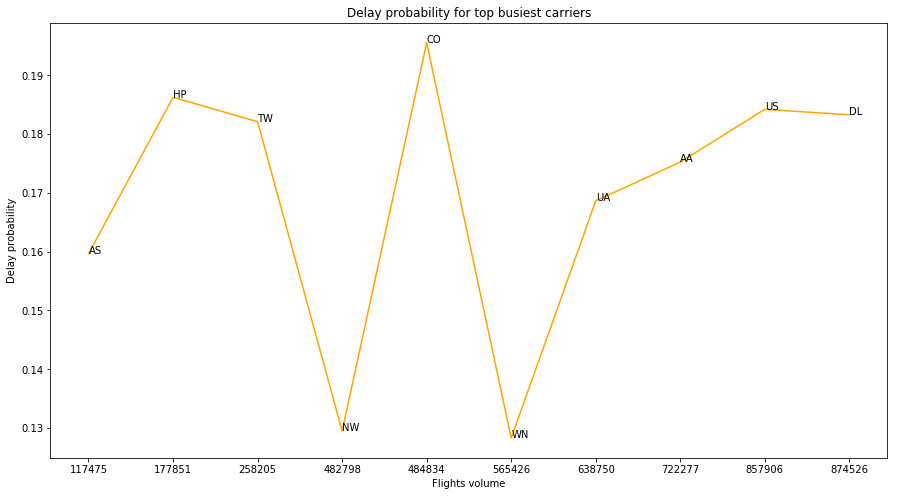

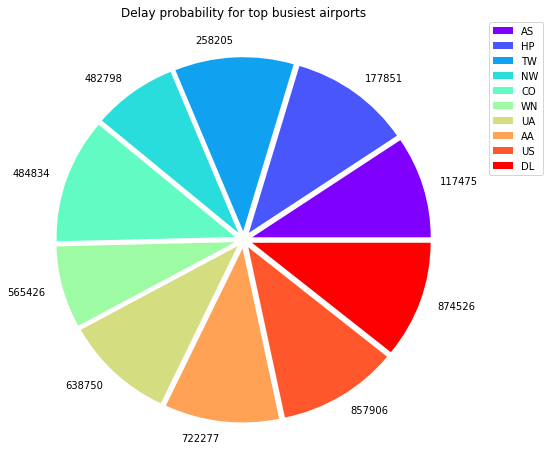

In [71]:
all_carriers = df.groupBy(df.carrier).count().orderBy('count', ascending=0)
# Top 20 Busiest carriers
top20_carriers = all_carriers.head(20)
# Total delayed flights per carrier.
delayed_flights_per_carrier = df[df.arrival_delay >= 15].groupBy(df.carrier).agg(func.count('*').alias('delayed_flights'))


carriers_delay = df_with_delay.filter(df_with_delay['carrier'].isin([x[0] for x in top20_carriers]))
carriers_delay = carriers_delay.groupBy('carrier')\
    .agg((func.sum('is_delay')/func.count('*')).alias('delay_ratio'),
        (func.count('*')).alias('n_flights'))\
    .orderBy('n_flights', ascending=False)
#Join the previous dfs based on the the attribute 'carrier'
data = all_carriers.join(carriers_delay, on='carrier').select('*').orderBy('count').collect()
# plot bar chart 
fig, ax = plt.subplots(figsize=(20,8))
ax.bar([x for x in range(len(joined_carriers_delay))], [x[1] for x in joined_carriers_delay], 0.25, color = 'g')
ax.set_ylabel('Flight volume')
ax2 = ax.twinx()
bars_delay = (plt.bar([x+0.25 for x in range(len(joined_carriers_delay))], 
            [x[2] for x in joined_carriers_delay], 0.25, color = 'orange'))
ax2.set_ylabel('Delay probability')

dr_patch = mpatches.Patch(color='g', label='total flights')
nf_patch = mpatches.Patch(color='orange', label='Delay percentage')
plt.legend(handles=[dr_patch,nf_patch])
plt.xticks([x+0.25 for x in range(len(joined_carriers_delay))], [x[0] for x in joined_carriers_delay])
plt.title('Delay percentage and flight volume for top 20 bussiest carriers')
plt.show()


# PLOT (line chart with x=airport, y1=flight volume, y2=delay)
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(111)
ax.set_title('Delay probability and flight volume for top busiest airports')
ax.plot([x for x in range(len(data))], [x[1] for x in data],c='g')
ax.set_xlabel('Top busiest carriers')
ax.set_ylabel('Flight volume', color='g')
ax2 = ax.twinx()
ax2.plot([x for x in range(len(data))], [x[2] for x in data], c='orange')
ax2.set_ylabel('Delay probability', color='orange')
plt.xticks([x for x in range(len(data))], [x[0] for x in data])
plt.show()

# PLOT (line chart)
plt.figure(figsize=(15,8))
plt.plot([x for x in range(len(data))], [x[2] for x in data],c='orange')
plt.xticks([x for x in range(len(data))], [x[1] for x in data])
for x in range(len(data)):
    plt.annotate('%s' % data[x][0], xy=(x, data[x][2]))
plt.title('Delay probability for top busiest carriers')
plt.ylabel('Delay probability')
plt.xlabel('Flights volume')
plt.show()

# PLOT (pie chart)
plt.figure(figsize=(8,8))
patches, _ =plt.pie([x[2] for x in data], 
        explode=[0.05 for _ in range(len(data))], 
        colors=cm.rainbow(np.linspace(0, 1, len(data))), 
        labels=[x[1] for x in data])
plt.legend(patches, [x[0] for x in data], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Delay probability for top busiest airports')
plt.show()

## Addition (bonus) questions

### Additional data
In the HDFS file system you have used for running the Notebook, you will notice that there are several other years available (in addition to 1994).

There are some other datasets that related to this use case:

- Airport IATA Codes to City names and Coordinates mapping: http://stat-computing.org/dataexpo/2009/airports.csv
- Carrier codes to Full name mapping: http://stat-computing.org/dataexpo/2009/carriers.csv
- Information about individual planes: http://stat-computing.org/dataexpo/2009/plane-data.csv
- Weather information: http://www.wunderground.com/weather/api/. You can subscribe for free to the developers' API and obtain (at a limited rate) historical weather information in many different formats. Also, to get an idea of the kind of information is available, you can use this link: http://www.wunderground.com/history/

### Question 5.1

<div class="alert alert-info">

Which airports are present in the dataset only as destination airport?

Which airport is present only as source airport in the dataset? 

</div>

### Question 5.2

<div class="alert alert-info">

Which airports have biggest delay probability ?

Which cities have largest delay duration in average ?

</div>

### Question 5.3

<div class="alert alert-info">

Is there any relationship between weather condition and the delay of flights in 1994 ?

</div>
